# 2 - Updated Sentiment Analysis

In the previous notebook, we got the fundamentals down for sentiment analysis. In this notebook, we'll actually get decent results.

We will use:
- pre-trained word embeddings
- different RNN architecture
- bidirectional RNN
- multi-layer RNN
- regularization
- a different optimizer

This will allow us to achieve ~85% test accuracy.

In [1]:
! git branch

  crossover_attention
  custom_model
  dev
  master
* swapdim


## Preparing Data

The same as before, we'll set the seed, define the `Fields` and get the train/valid/test splits.

In [2]:
import torch
from torchtext import data
from torchtext import datasets
import random

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import pandas as pd

In [4]:
df_train = pd.read_pickle('./data/processed/wikiqa_df_train.pickle')
df_test = pd.read_pickle('./data/processed/wikiqa_df_test.pickle')
df_val = pd.read_pickle('./data/processed/wikiqa_df_val.pickle')

In [5]:
for i in (df_train.head(3), df_val.head(3), df_test.head(3)):
    print(i)

  QuestionID                      Question DocumentID DocumentTitle  \
0         Q1  how are glacier caves formed         D1  Glacier cave   
1         Q1  how are glacier caves formed         D1  Glacier cave   
2         Q1  how are glacier caves formed         D1  Glacier cave   

  SentenceID                                           Sentence  Label  \
0       D1-0  a partly submerged glacier cave on perito more...      0   
1       D1-1             the ice facade is approximately m high      0   
2       D1-2          ice formations in the titlis glacier cave      0   

                                    Question_encoded  \
0  [198, 33, 9683, 11375, 1348, 0, 0, 0, 0, 0, 0,...   
1  [198, 33, 9683, 11375, 1348, 0, 0, 0, 0, 0, 0,...   
2  [198, 33, 9683, 11375, 1348, 0, 0, 0, 0, 0, 0,...   

                                    Sentence_encoded  
0  [8, 3547, 14174, 9683, 6543, 14, 153763, 12691...  
1  [1, 1719, 13522, 15, 2128, 1994, 153, 0, 0, 0,...  
2  [1719, 14062, 7, 1, 35014

The first addition is the use of pre-trained word embeddings. Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors.
We get these vectors simply by specifying which vectors we want, and passing it as an argument to `build_vocab`. Here, we'll be using the `"glove.6B.100d" vectors"`. `glove` is the algorithm used to calculate the vectors, go [here](https://nlp.stanford.edu/projects/glove/) for more. `6B` indicates these vectors were trained on 6 billion tokens and `100d` indicates these vectors are 100-dimensional.

You can see the other available vectors [here](https://github.com/pytorch/text/blob/master/torchtext/vocab.py#L113).

The theory is that these pre-trained vectors already have words with similar semantic meaning close together in vector space, e.g. "terrible", "awful", "dreadful" are nearby. This gives our embedding layer a good initialization as it does not have to learn these relations from scratch.

**Note**: these vectors are about 862MB, so watch out if you have a limited internet connection.

In [130]:
BATCH_SIZE = 1024

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [131]:
import math 
class SelfAttention():
    def __init__(self, dropout=None, positional_encoding=False):
        if dropout:
            # TODO: dropout
            raise NotImplementedError()
        if positional_encoding:
            # TODO: positional encoding
            raise NotImplementedError()
        pass

    @staticmethod
    def self_attention(query, key, value):
        d_k = value.size(-1)
        score = torch.bmm(query, key.permute(0,2,1))
        score = score / math.sqrt(d_k)
        # TODO: потенциально слабое место с направлением softmax'a.
        p_att = F.softmax(score, dim=-1)
        score = torch.bmm(p_att, value)
        return score, p_att

In [132]:
import torch.nn as nn
from torch.nn import functional as F
class MultiheadAttention(nn.Module):
    def __init__(self, n_heads, emb_size, att_size=128, dropout=None):
        super(MultiheadAttention, self).__init__()
#         if dropout:
#             # TODO: dropout
#             raise NotImplementedError
        self.n_heads = n_heads
        self.emb_size = emb_size
        self.att_size = att_size
        self.attention = SelfAttention().self_attention
        # (W_q) n_heads times:
        self.linear_query = nn.ModuleList([nn.Linear(self.emb_size, self.att_size) for _ in range(self.n_heads)])
        # (W_k) n_heads times:
        self.linear_key = nn.ModuleList([nn.Linear(self.emb_size, self.att_size) for _ in range(self.n_heads)])
        # (W_v) n_heads times:
        self.linear_value = nn.ModuleList([nn.Linear(self.emb_size, self.att_size) for _ in range(self.n_heads)])
        # Fields for keeping attended values and attention_probabilities
        self.att_probas = []    # n_heads х n_sentences x max_len x max_len
        self.scores = []
        # Linear layer to transform concatenated heads
        self.output_linear = nn.Linear(n_heads*att_size, emb_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        # for each head:
        for head in range(self.n_heads):
            q = self.dropout(self.linear_query[head](query))
            k = self.dropout(self.linear_key[head](key))
            v = self.dropout(self.linear_value[head](value))
            # Scaled dot-product attention:
            score, p_att = self.attention(q,k,v)
            self.att_probas.append(p_att)
            self.scores.append(score)
        # Concatenate resulting matrices concat(z_0, z_1, ... z__n_heads)
        scores = torch.cat(self.scores, -1)
        # Transform concatenated
        scores = self.dropout(self.output_linear(scores))
        # Update attention probabilities for every head
        att_probas = self.att_probas
        # Reset scores and probabilities
        self.scores = []
        self.att_probas = []
        return scores, att_probas

In [133]:
class AttentionFlattener(nn.Module):
    def __init__(self, seq_len):
        super(AttentionFlattener, self).__init__()
        self.attention_matrix = None
        self.linear = nn.Linear(seq_len, 1)
#         self.softmax = nn.Softmax(1)
        pass

    def forward(self, x):
        self.attention_matrix = x
        scores = self.linear(self.attention_matrix)
        scores = F.softmax(scores, dim=1)
        return scores

## Build the Model

The model features the most drastic changes.

### Different RNN Architecture

We'll be using a different RNN architecture called a Long Short-Term Memory (LSTM). Why is an LSTM better than a standard RNN? Standard RNNs suffer from the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). LSTMs overcome this by having an extra recurrent state called a _cell_, $c$ - which can be thought of as the "memory" of the LSTM - and the use use multiple _gates_ which control the flow of information into and out of the memory. For more information, go [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). We can simply think of the LSTM as a function of $x_t$, $h_t$ and $c_t$, instead of just $x_t$ and $h_t$.

$$(h_t, c_t) = \text{LSTM}(x_t, h_t, c_t)$$

Thus, the model using an LSTM looks something like:

![](assets/sentiment2.png)

The initial cell state, $c_0$, like the initial hidden state is initialized to a tensor of all zeros. The sentiment prediction is still, however, only made using the final hidden state, not the final cell state, i.e. $\hat{y}=f(h_T)$.

### Bidirectional RNN

The concept behind a bidirectional RNN is simple. As well as having an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the **last to the first** (a backward RNN). In PyTorch, the hidden state (and cell state) tensors returned by the forward and backward RNNs are stacked on top of each other. We make our sentiment prediction using the last hidden state from the forward RNN (obtained from final word of the sentence), $h_T^\rightarrow$, and the last hidden state from the backward RNN (obtained from the first word of the sentence), $h_T^\leftarrow$, i.e. $\hat{y}=f(h_T^\rightarrow, h_T^\leftarrow)$   

The image below shows a bi-directional RNN, with the forward RNN in orange, the backward RNN in green and the linear layer in silver.  

![](assets/sentiment3.png)

### Multi-layer RNN

Multi-layer RNNs (also called *deep RNNs*) are another simple concept. The idea is that we add additional RNNs on top of the initial standard RNN, where each RNN added is another *layer*. The hidden state output by the first (bottom) RNN at time-step $t$ will be the input to the RNN above it at time step $t$. The prediction is then made from the final hidden state of the final (highest) layer.

The image below shows a multi-layer unidirectional RNN, where the layer number is given as a superscript. Also note that each layer needs their own initial hidden state, $h_0^L$.

![](assets/sentiment4.png)

### Regularization

Although we've added improvements to our model, each one adds additional parameters. Without going into overfitting into to much detail, the more parameters you have in in your model, the higher the probability that your model will overfit (memorize the training data, causing  a low training error but high validation/testing error, i.e. poor generalization to new, unseen examples). To combat this, we use regularization. More specifically, we use a method of regularization called *dropout*. Dropout works by randomly *dropping out* (setting to 0) neurons in a layer during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered indepenently. One theory about why dropout works is that a model with parameters dropped out can be seen as a "weaker" (less parameters) model. The predictions from all these "weaker" models (one for each forward pass) get averaged together withinin the parameters of the model. Thus, your one model can be thought of as an ensemble of weaker models, none of which are over-parameterized and thus should not overfit.

### Implementation Details

To use an LSTM instead of the standard RNN, we use `nn.LSTM` instead of `nn.RNN`. Also, note that the LSTM returns the `output` and a tuple of the final `hidden` state and the final `cell` state, whereas the standard RNN only returned the `output` and final `hidden` state. 

As the final hidden state of our LSTM has both a forward and a backward component, which will be concatenated together, the size of the input to the `nn.Linear` layer is twice that of the hidden dimension size.

Implementing bidirectionality and adding additional layers are done by passing values for the `num_layers` and `bidirectional` arguments for the RNN/LSTM. 

Dropout is implemented by initializing an `nn.Dropout` layer (the argument is the probability of dropping out each neuron) and using it within the `forward` method after each layer we want to apply dropout to. **Note**: never use dropout on the input or output layers (`x` or `fc` in this case), you only ever want to use dropout on intermediate layers. The LSTM has a `dropout` argument which adds dropout on the connections between hidden states in one layer to hidden states in the next layer. 

The final hidden state, `hidden`, has a shape of _**[num layers * num directions, batch size, hid dim]**_. These are ordered: **[forward_layer_0, backward_layer_0, forward_layer_1, backward_layer 1, ..., forward_layer_n, backward_layer n]**. As we want the final (top) layer forward and backward hidden states, we get the top two hidden layers from the first dimension, `hidden[-2,:,:]` and `hidden[-1,:,:]`, and concatenate them together before passing them to the linear layer (after applying dropout). 

In [134]:
import torch.nn as nn
from torch.nn import functional as F


class RNN_3(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers, bidirectional, dropout, q_len, a_len):
        super().__init__()
        
        self.embedding_l = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_r = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn_l = nn.GRU(embedding_dim, hidden_dim,
                           num_layers=n_layers, bidirectional=bidirectional,
                           dropout=dropout, batch_first=True)
        self.rnn_r = nn.GRU(embedding_dim, hidden_dim,
                           num_layers=n_layers, bidirectional=bidirectional,
                           dropout=dropout, batch_first=True)
        
        self.att_l = MultiheadAttention(1, hidden_dim, hidden_dim, dropout)
        self.att_r = MultiheadAttention(1, hidden_dim, hidden_dim, dropout)
        
        self.l_flattener = AttentionFlattener(q_len)
        self.r_flattener = AttentionFlattener(a_len)
        
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.l_probas = None
        self.r_probas = None
        
    def forward(self, x_l, x_r):
        
        #x = [sent len, batch size]
        
        embedded_l = self.dropout(self.embedding_l(x_l))
        embedded_r = self.dropout(self.embedding_r(x_r))
        
        output_l, hidden_l = self.rnn_l(embedded_l)
        output_r, hidden_r = self.rnn_r(embedded_r)
        
        h_l, probas_l = self.att_l(output_l, output_r, output_r)
        h_r, probas_r = self.att_r(output_r, output_l, output_l)

        probas_l = self.l_flattener(probas_l[0])
        probas_r = self.r_flattener(probas_r[0])
        
#         print(probas_l.shape, hidden_l.shape, hidden_r.shape, probas_r.shape)
        hidden_l = probas_l * h_l
        hidden_r = probas_r * h_r
        
        hidden_l = torch.mean(hidden_l, dim=1)
        hidden_r = torch.mean(hidden_r, dim=1)
        
        hidden = torch.cat((hidden_l, hidden_r), dim=1)
        self.l_probas = probas_l
        self.r_probas = probas_r
        return self.fc(hidden.squeeze(0))


class RNN_2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.embedding_l = nn.Embedding(vocab_size, embedding_dim)
        self.rnn_l = nn.LSTM(embedding_dim, hidden_dim,
                           num_layers=n_layers, bidirectional=bidirectional,
                           dropout=dropout, batch_first=True)
        self.att_l = MultiheadAttention(3, hidden_dim, hidden_dim, dropout=dropout)
        
        self.embedding_r = nn.Embedding(vocab_size, embedding_dim)
        self.rnn_r = nn.LSTM(embedding_dim, hidden_dim,
                           num_layers=n_layers, bidirectional=bidirectional,
                           dropout=dropout, batch_first=True)
        self.att_r = MultiheadAttention(3, hidden_dim, hidden_dim, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.l_probas = None
        self.r_probas = None
        
    def forward(self, x_l, x_r):
        
        #x = [sent len, batch size]
        
        embedded_l = self.dropout(self.embedding_l(x_l))
        embedded_r = self.dropout(self.embedding_r(x_r))
#         print(embedded.size())
        
        #embedded = [sent len, batch size, emb dim]
        
        output_l, (hidden_l, cell_l) = self.rnn_l(embedded_l)
        output_r, (hidden_r, cell_r) = self.rnn_r(embedded_r)
        
        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        hidden_l, probas_l = self.att_l(output_l, output_r, output_r)
        hidden_r, probas_r = self.att_r(output_r, output_l, output_l)
        hidden_l = torch.mean(hidden_l, dim=1)
        hidden_r = torch.mean(hidden_r, dim=1)
        hidden = torch.cat((hidden_l, hidden_r), dim=1)
#         print(hidden_l.shape, hidden_r.shape, hidden.shape)
        self.l_probas = probas_l
        self.r_probas = probas_r
#         print(hidden.size())
#         hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
                
        #hidden = [batch size, hid dim * num directions]
#         print(hidden.squeeze(0).shape)
        return self.fc(hidden.squeeze(0))
      
    
    
class RNN_1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional):
        super().__init__()
        
        self.embedding_l = nn.Embedding(vocab_size, embedding_dim)
        self.rnn_l = nn.LSTM(embedding_dim, hidden_dim,
                           num_layers=n_layers, bidirectional=bidirectional,
                           dropout=dropout, batch_first=True)
        
        self.embedding_r = nn.Embedding(vocab_size, embedding_dim)
        self.rnn_r = nn.LSTM(embedding_dim, hidden_dim,
                           num_layers=n_layers, bidirectional=bidirectional,
                           dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x_l, x_r):
        
        #x = [sent len, batch size]
        
        embedded_l = self.dropout(self.embedding_l(x_l))
        embedded_r = self.dropout(self.embedding_r(x_r))
#         print(embedded.size())
        
        #embedded = [sent len, batch size, emb dim]
        
        output_l, (hidden_l, cell_l) = self.rnn_l(embedded_l)
        output_r, (hidden_r, cell_r) = self.rnn_r(embedded_r)
        
        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
#         hidden_l = self.dropout(torch.mean(output_l, dim=1))
#         hidden_r = self.dropout(torch.mean(output_r, dim=1))
        hidden = torch.cat((hidden_l[0], hidden_r[0]), dim=1)
#         print(hidden_l.shape, hidden_r.shape, hidden.shape)
#         hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
                
        #hidden = [batch size, hid dim * num directions]
#         print(hidden.squeeze(0).shape)
        return self.fc(hidden.squeeze(0))

Like before, we'll create an instance of our RNN class, with the new parameters and arguments for the number of layers, bidirectionality and dropout probability.

To ensure the pre-trained vectors can be loaded into the model, the `EMBEDDING_DIM` must be equal to that of the pre-trained GloVe vectors loaded earlier.

In [135]:
import numpy as np

In [136]:
pretrained_embeddings = np.load('./data/processed/index2vector.npy')

In [137]:
pretrained_embeddings.shape

(400002, 200)

In [138]:
INPUT_DIM = len(pretrained_embeddings)
EMBEDDING_DIM = 200
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.2

model = RNN_3(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
              N_LAYERS, BIDIRECTIONAL, DROPOUT, df_train.Sentence_encoded.apply(len).max(),
              df_train.Question_encoded.apply(len).max())

/home/jupyter/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


The final addition is copying the pre-trained word embeddings we loaded earlier into the `embedding` layer of our model.

We retrieve the embeddings from the field's vocab, and check they're the correct size, _**[vocab size, embedding dim]**_ 

In [139]:
print(pretrained_embeddings.shape)

(400002, 200)


We then replace the initial weights of the `embedding` layer with the pre-trained embeddings.

In [140]:
# model.embedding_l.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
# model.embedding_r.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
model.embedding_l.from_pretrained(torch.from_numpy(pretrained_embeddings), freeze=True)
model.embedding_r.from_pretrained(torch.from_numpy(pretrained_embeddings), freeze=True)

Embedding(400002, 200)

In [141]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

160136664

In [142]:
model.embedding_l.weight.requires_grad=False
model.embedding_r.weight.requires_grad=False

In [143]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

135864

## Train the Model

Now to training the model.

The only change we'll make here is changing the optimizer from `SGD` to `Adam`. SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. `Adam` adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates. More information about `Adam` (and other optimizers) can be found [here](http://ruder.io/optimizing-gradient-descent/index.html).

To change `SGD` to `Adam`, we simply change `optim.SGD` to `optim.Adam`, also note how we do not have to provide an initial learning rate for Adam as PyTorch specifies a sensibile default initial learning rate.

In [144]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

The rest of the steps for training the model are unchanged.

We define the criterion and place the model and criterion on the GPU (if available)...

In [145]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [146]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

We define a function for training our model...

**Note**: as we are now using dropout, we must remember to use `model.train()` to ensure the dropout is "turned on" while training.

In [147]:
df_train.head(3)

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label,Question_encoded,Sentence_encoded
0,Q1,how are glacier caves formed,D1,Glacier cave,D1-0,a partly submerged glacier cave on perito more...,0,"[198, 33, 9683, 11375, 1348, 0, 0, 0, 0, 0, 0,...","[8, 3547, 14174, 9683, 6543, 14, 153763, 12691..."
1,Q1,how are glacier caves formed,D1,Glacier cave,D1-1,the ice facade is approximately m high,0,"[198, 33, 9683, 11375, 1348, 0, 0, 0, 0, 0, 0,...","[1, 1719, 13522, 15, 2128, 1994, 153, 0, 0, 0,..."
2,Q1,how are glacier caves formed,D1,Glacier cave,D1-2,ice formations in the titlis glacier cave,0,"[198, 33, 9683, 11375, 1348, 0, 0, 0, 0, 0, 0,...","[1719, 14062, 7, 1, 350149, 9683, 6543, 0, 0, ..."


In [148]:
data = df_train.loc[:, ['Question_encoded', 'Sentence_encoded', 'Label']]

lst = [data]
max_size = df_train.Label.value_counts().max()
for class_index, group in data.groupby('Label'):
    lst.append(group.sample(max_size-len(group), replace=True))
data = pd.concat(lst)
data.loc[:, 'Label'] = data.loc[:, 'Label'].apply(lambda x: 1. if x==1 else 0)

data_val = df_val.loc[:, ['Question_encoded', 'Sentence_encoded', 'Label']]
lst = [data_val]
max_size = df_val.Label.value_counts().max()
for class_index, group in data_val.groupby('Label'):
    lst.append(group.sample(max_size-len(group), replace=True))
data_val = pd.concat(lst)
data_val.loc[:, 'Label'] = data_val.loc[:, 'Label'].apply(lambda x: 1. if x==1 else 0.)

data_test = df_test.loc[:, ['Question_encoded', 'Sentence_encoded', 'Label']]
data_test.loc[:, 'Label'] = data_test.loc[:, 'Label'].apply(lambda x: 1. if x==1 else 0.)

In [149]:
def data_iterator(df, batch_size, X_colname_l, X_colname_r, y_colname, device):
    lb = 0
    rb = batch_size
    while lb < len(df):
        X_l = df.iloc[lb:rb].loc[:, X_colname_l].values.tolist()
        X_r = df.iloc[lb:rb].loc[:, X_colname_r].values.tolist()
        X_l = torch.from_numpy(np.array(X_l)).to(device)
        X_r = torch.from_numpy(np.array(X_r)).to(device)
        y = df.iloc[lb:rb].loc[:, y_colname].values.tolist()
        y = torch.from_numpy(np.array(y).astype('float32')).to(device)
        lb += batch_size
        rb += batch_size
        yield X_l, X_r, y

In [150]:
def train(model, iterator, optimizer, criterion, clip=10.):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    iteration = 1
    for X_l, X_r, y in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(X_l, X_r).squeeze(1)
#         print(X.shape)
        
        loss = criterion(predictions, y)
        
        acc = binary_accuracy(predictions, y)
        
        loss.backward()
        _ = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        iteration += 1
        
    return epoch_loss / iteration, epoch_acc / iteration

We define a function for testing our model...

**Note**: as we are now using dropout, we must remember to use `model.eval()` to ensure the dropout is "turned off" while evaluating.

In [151]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    iteration = 1
    with torch.no_grad():
    
        for X_l, X_r, y in iterator:
            
            predictions = model(X_l, X_r).squeeze(1)
            
            loss = criterion(predictions, y)
            
            acc = binary_accuracy(predictions, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            iteration += 1
    return epoch_loss / iteration, epoch_acc / iteration

Finally, we train our model...

In [ ]:
N_EPOCHS = 7

for epoch in range(N_EPOCHS):
    data = data.sample(frac=1., random_state=epoch)
    data_val = data_val.sample(frac=1., random_state=epoch)
    
    train_iterator = data_iterator(data, BATCH_SIZE, 'Question_encoded',
                                   'Sentence_encoded', 'Label', device)
    valid_iterator = data_iterator(data_val, BATCH_SIZE, 'Question_encoded',
                                   'Sentence_encoded', 'Label', device)

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 0.663 | Train Acc: 56.81% | Val. Loss: 0.552 | Val. Acc: 52.94% |
| Epoch: 02 | Train Loss: 0.567 | Train Acc: 67.50% | Val. Loss: 0.562 | Val. Acc: 56.17% |
| Epoch: 03 | Train Loss: 0.449 | Train Acc: 76.88% | Val. Loss: 0.604 | Val. Acc: 58.85% |
| Epoch: 04 | Train Loss: 0.309 | Train Acc: 84.81% | Val. Loss: 0.893 | Val. Acc: 57.33% |
| Epoch: 05 | Train Loss: 0.216 | Train Acc: 89.07% | Val. Loss: 0.997 | Val. Acc: 58.02% |
| Epoch: 06 | Train Loss: 0.165 | Train Acc: 91.42% | Val. Loss: 1.413 | Val. Acc: 57.84% |


In [121]:
data.shape

(38616, 3)

In [122]:
test_iterator = data_iterator(data_test.sample(n=16, random_state=8), 16, 'Question_encoded',
                               'Sentence_encoded', 'Label', device)


X_l, X_r, y = next(test_iterator)
y

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [123]:
model.eval()
y_pred = model(X_l, X_r)
att_mat_l = model.l_probas
att_mat_r = model.r_probas

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

def loadobj(path):
    with open(path, 'rb') as fin:
        return pickle.load(fin)

id2token = loadobj('./data/processed/index2word.pickle')

# i = 10
# i_head = 2
# q = X_l[i]
# a = X_r[i]
# l = y[3]
# model(q.unsqueeze(0),a.unsqueeze(0))
# l_mat = model.l_probas[i_head][0]
# r_mat = model.r_probas[i_head][0]

# q_s = ' '.join([id2token[i] for i in q.detach().tolist() if i != 0])
# print(q_s, '\n')

# a_s = ' '.join([id2token[i] for i in a.detach().tolist() if i != 0])
# print(a_s, '\n')

# print(l)


i = 4
i_head = 0
q = X_l[i]
a = X_r[i]
l = y[i]
model(q.unsqueeze(0),a.unsqueeze(0))
l_mat = model.l_probas.detach().cpu().numpy().flatten().reshape(1,-1)
r_mat = model.r_probas.detach().cpu().numpy().flatten().reshape(1,-1)

q_s = ' '.join([id2token[i] for i in q.detach().tolist() if i != 0])
print(q_s, '\n')

a_s = ' '.join([id2token[i] for i in a.detach().tolist() if i != 0])
print(a_s, '\n')

print(l)

what is the formula for calcium nitrate 

calcium nitrate also called <unk> norwegian saltpeter is the inorganic compound with the formula ca no 

tensor(1., device='cuda:0')


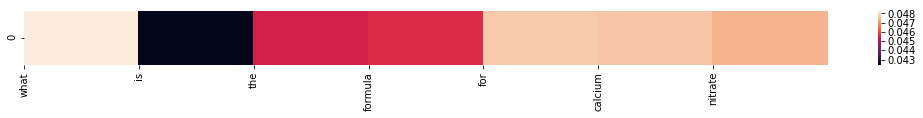

In [124]:
plt.figure(figsize=(18,1))
sns.heatmap(l_mat[:, :len(q_s.split())])
_ = plt.xticks(range(len(q_s.split())), q_s.split(), rotation=90)

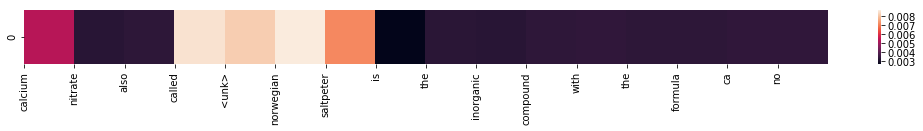

In [125]:
plt.figure(figsize=(18,1))
sns.heatmap(r_mat[:, :len(a_s.split())])
_ = plt.xticks(range(len(a_s.split())), a_s.split(), rotation=90)

...and get our new and vastly improved test accuracy!

In [126]:
test_iterator = data_iterator(data_val.sample(n=16, random_state=11), 16, 'Question_encoded',
                               'Sentence_encoded', 'Label', device)

In [127]:
X_l, X_r, y = next(test_iterator)
y

tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.],
       device='cuda:0')

In [128]:
model.eval()
y_pred = model(X_l, X_r)
att_mat_l = model.l_probas
att_mat_r = model.r_probas

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

def loadobj(path):
    with open(path, 'rb') as fin:
        return pickle.load(fin)

id2token = loadobj('./data/processed/index2word.pickle')

# i = 10
# i_head = 2
# q = X_l[i]
# a = X_r[i]
# l = y[3]
# model(q.unsqueeze(0),a.unsqueeze(0))
# l_mat = model.l_probas[i_head][0]
# r_mat = model.r_probas[i_head][0]

# q_s = ' '.join([id2token[i] for i in q.detach().tolist() if i != 0])
# print(q_s, '\n')

# a_s = ' '.join([id2token[i] for i in a.detach().tolist() if i != 0])
# print(a_s, '\n')

# print(l)


i = 12
i_head = 0
q = X_l[i]
a = X_r[i]
l = y[i]
model(q.unsqueeze(0),a.unsqueeze(0))
l_mat = model.l_probas.detach().cpu().numpy().flatten().reshape(1,-1)
r_mat = model.r_probas.detach().cpu().numpy().flatten().reshape(1,-1)

q_s = ' '.join([id2token[i] for i in q.detach().tolist() if i != 0])
print(q_s, '\n')

a_s = ' '.join([id2token[i] for i in a.detach().tolist() if i != 0])
print(a_s, '\n')

print(l)

how are epithelial tissues joined together 

in biology tissue is a cellular organizational level intermediate between cells and a complete organism 

tensor(0., device='cuda:0')


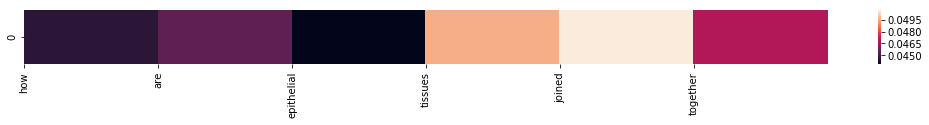

In [129]:
plt.figure(figsize=(18,1))
sns.heatmap(l_mat[:, :len(q_s.split())])
_ = plt.xticks(range(len(q_s.split())), q_s.split(), rotation=90)

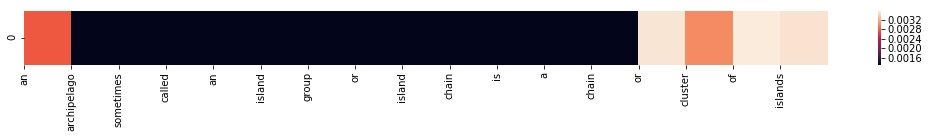

In [90]:
plt.figure(figsize=(18,1))
sns.heatmap(r_mat[:, :len(a_s.split())])
_ = plt.xticks(range(len(a_s.split())), a_s.split(), rotation=90)

In [55]:
test_iterator = data_iterator(data_val.sample(n=16, random_state=19), 16, 'Question_encoded',
                               'Sentence_encoded', 'Label', device)

In [56]:
X_l, X_r, y = next(test_iterator)
y

tensor([1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
       device='cuda:0')

In [57]:
model.eval()
y_pred = model(X_l, X_r)
att_mat_l = model.l_probas
att_mat_r = model.r_probas

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

def loadobj(path):
    with open(path, 'rb') as fin:
        return pickle.load(fin)

id2token = loadobj('./data/processed/index2word.pickle')

# i = 10
# i_head = 2
# q = X_l[i]
# a = X_r[i]
# l = y[3]
# model(q.unsqueeze(0),a.unsqueeze(0))
# l_mat = model.l_probas[i_head][0]
# r_mat = model.r_probas[i_head][0]

# q_s = ' '.join([id2token[i] for i in q.detach().tolist() if i != 0])
# print(q_s, '\n')

# a_s = ' '.join([id2token[i] for i in a.detach().tolist() if i != 0])
# print(a_s, '\n')

# print(l)


i = 15
i_head = 0
q = X_l[i]
a = X_r[i]
l = y[i]
model(q.unsqueeze(0),a.unsqueeze(0))
l_mat = model.l_probas.detach().cpu().numpy().flatten().reshape(1,-1)
r_mat = model.r_probas.detach().cpu().numpy().flatten().reshape(1,-1)

q_s = ' '.join([id2token[i] for i in q.detach().tolist() if i != 0])
print(q_s, '\n')

a_s = ' '.join([id2token[i] for i in a.detach().tolist() if i != 0])
print(a_s, '\n')

print(l)

what is the function of albumin 

albumin transports hormones fatty acids and other compounds buffers ph and maintains osmotic pressure among other functions 

tensor(1., device='cuda:0')


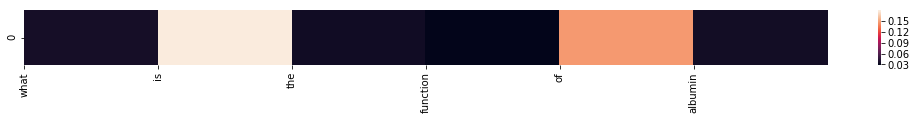

In [58]:
plt.figure(figsize=(18,1))
sns.heatmap(l_mat[:, :len(q_s.split())])
_ = plt.xticks(range(len(q_s.split())), q_s.split(), rotation=90)

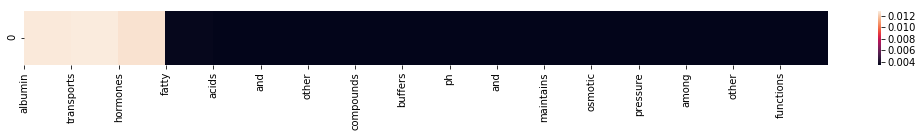

In [59]:
plt.figure(figsize=(18,1))
sns.heatmap(r_mat[:, :len(a_s.split())])
_ = plt.xticks(range(len(a_s.split())), a_s.split(), rotation=90)

## User Input

We can now use our model to predict the sentiment of any sentence we give it. As it has been trained on movie reviews, the sentences provided should also be movie reviews.

Our `predict_sentiment` function does a few things:
- tokenizes the sentence, i.e. splits it from a raw string into a list of tokens
- indexes the tokens by converting them into their integer representation from our vocabulary
- converts the indexes, which are a Python list into a PyTorch tensor
- add a batch dimension by `unsqueeze`ing 
- squashes the output prediction from a real number between 0 and 1 with the `sigmoid` function
- converts the tensor holding a single value into an integer with the `item()` method

We are expecting reviews with a negative sentiment to return a value close to 0 and positive reviews to return a value close to 1.

In [ ]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

An example negative review...

In [ ]:
predict_sentiment("This film is terrible")

An example positive review...

In [ ]:
predict_sentiment("This film is great")

## Next Steps

We've now built a decent sentiment analysis model for movie reviews. However, not all of the steps we have added were necessary to achieve the test accuracy we've achieved. In the next notebook we'll implement a model that gets comparable accuracy with far fewer parameters and trains much, much faster.